# Preamble

In [263]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from datetime import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER
from metpy.calc import divergence,vorticity
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

def pra_cmap(full=True,white=True):
    '''
    An alternative colormap
    '''
    newcmap=[
        (0.8313725490196079, 0.23921568627450981, 0.30980392156862746),
        (0.9529411764705882, 0.4196078431372549, 0.26666666666666666),
        (0.9921568627450981, 0.6666666666666666, 0.37254901960784315),
        (0.996078431372549, 0.8627450980392157, 0.5333333333333333),
        (1, 1,1),
        (0.9176470588235294, 0.9647058823529412, 0.6431372549019608),
        (0.7058823529411765, 0.8784313725490196, 0.6352941176470588),
        (0.4549019607843137, 0.6980392156862745, 0.7450980392156863),
        (0.25294117647058826, 0.38627450980392156, 0.7294117647058823)]

    n=4 if white else 5
    newcmap = mpl.colors.LinearSegmentedColormap.from_list('new_map',newcmap) if full else \
        mpl.colors.LinearSegmentedColormap.from_list('new_map',newcmap[n:])
    
    if full: 
        newcmap.set_under((0.6196078431372549,0.00392156862745098,0.25882352941176473))
    else:
        if white: newcmap.set_under((1,1, 1)) 
            
    newcmap.set_over((0.25098039215686274, 0.1803921568627451, 0.5019607843137255))
    return newcmap

def regrid_xr(ds,res=2.5):
    '''
    regrid ds to resolution res
    '''
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], np.arange(-25, 25, res)),
            "lon": (["lon"], np.arange(0, 360, res)),
        }
    )

    regridder = xe.Regridder(ds, ds_out, "bilinear")
    return(regridder(ds))

def contour_quiver_6(toplot,wind_xr,levels,scale=30):
    '''
    Function to plot contours on a 3x2 plot with overlaid vectors
    
    toplot:  an xarray of dim latxlon for coloured contours
    wind_xr:  an xarray with u and v for wind vectors
    
    '''
    wind_xr=regrid_xr(wind_xr,res=2.5).sel(lat=slice(-5,15),lon=slice(94,113))

    fig,axs=plt.subplots(figsize=[10,8],nrows=2,ncols=3,
             gridspec_kw={'top':0.93,'bottom':0.06,'left':0.08,'right':0.96,'wspace':0.35},
                     subplot_kw={'projection':ccrs.PlateCarree(180)})
    for i,ax in enumerate(np.ravel(axs)):
        cont=toplot[i].sel(lat=slice(-5,15),lon=slice(94,113)).plot.contourf(
            ax=ax,add_colorbar=False,levels=levels,transform=ccrs.PlateCarree())
        qu=wind_xr.isel(time=i).plot.quiver(x='lon',y='lat',scale=scale,add_guide=False,
                             u='eastward_wind',v='northward_wind',ax=ax,
                             transform=ccrs.PlateCarree(),zorder=4)
        ax.set(title='',ylabel='',xlabel='')
        ax.coastlines(zorder=4)
        gl=ax.gridlines(draw_labels=True,linestyle='dashed',zorder=3)
        gl.top_labels=False;gl.right_labels=False

    plt.quiverkey(qu,0.93, 0.95, 5, r'$5 \frac{m}{s}$', labelpos='E',
                       coordinates='figure')
    cb=plt.colorbar(cont,ax=axs,orientation='horizontal',fraction=0.05,aspect=60,pad=0.08,ticks=levels)
    
    return(fig,axs,cb)

# Load wave data and example file contents

Contents are a subset of full file
11/2018 - 12/2018

In [248]:
ncs={kind:xr.open_mfdataset('./wave_input/{0}_*_ERA5_6hr.nc'.format(kind)) 
     for kind in ['Kelvin','R1','R2','WMRG']}
print(ncs['Kelvin'])

<xarray.Dataset>
Dimensions:        (time: 244, lat: 49, lon: 360)
Coordinates:
  * lat            (lat) float64 -24.0 -23.0 -22.0 -21.0 ... 21.0 22.0 23.0 24.0
  * lon            (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time           (time) datetime64[ns] 2018-11-01 ... 2018-12-31T18:00:00
Data variables:
    eastward_wind  (time, lat, lon) float64 dask.array<chunksize=(120, 49, 360), meta=np.ndarray>
    divergence     (time, lat, lon) float64 dask.array<chunksize=(120, 49, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.5
    history:      Tue Nov  2 10:22:36 2021: ncks -C -O -x -v day_of_year uz_K...
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...


# Plot divergence for required times

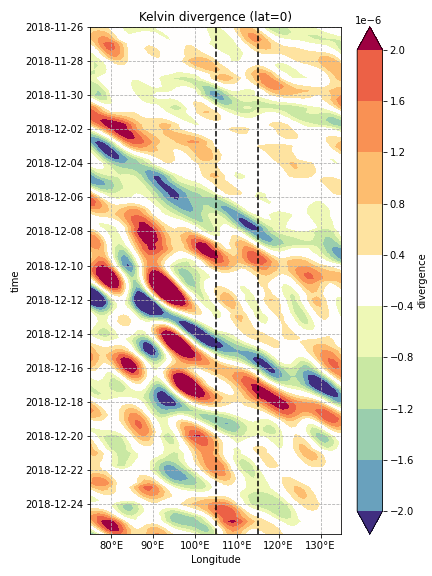

In [249]:
levels=np.arange(-2e-6,2.1e-6,4e-7)
levels=levels[~np.equal(levels,0)]
div_casestudy=ncs['Kelvin'].divergence.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime(2018,11,26),datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),ax=ax)
ax.set(title='Kelvin divergence (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
plt.tight_layout()

# Repeat for R1, R2 and WMRG variables

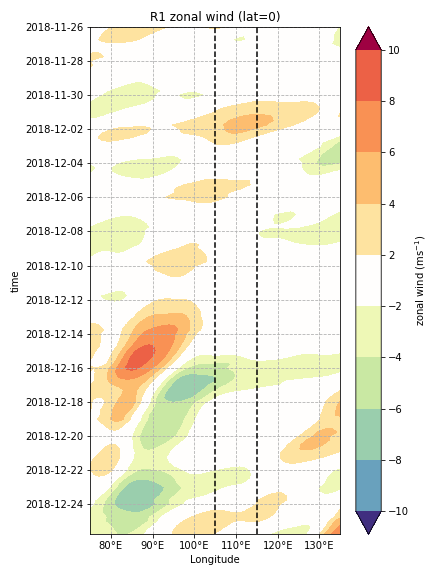

In [220]:
levels=np.arange(-10,11,2)
levels=levels[~np.equal(levels,0)]
div_casestudy=ncs['R1'].eastward_wind.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime(2018,11,26),datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'zonal wind (ms$^{-1}$)','ticks':levels})
ax.set(title='R1 zonal wind (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
plt.tight_layout()

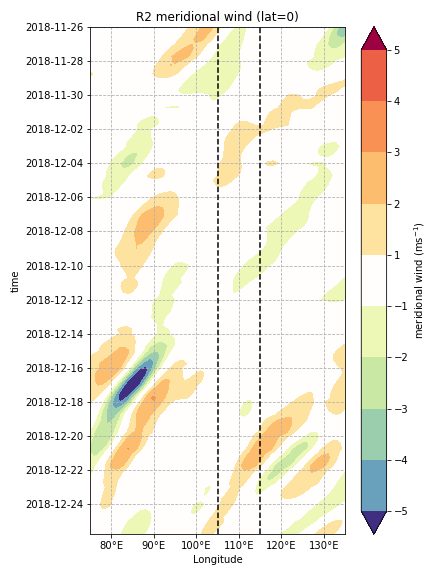

In [221]:
levels=np.arange(-5,6,1)
levels=levels[~np.equal(levels,0)]
div_casestudy=ncs['R2'].northward_wind.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime(2018,11,26),datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'meridional wind (ms$^{-1}$)'})
ax.set(title='R2 meridional wind (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
plt.tight_layout()

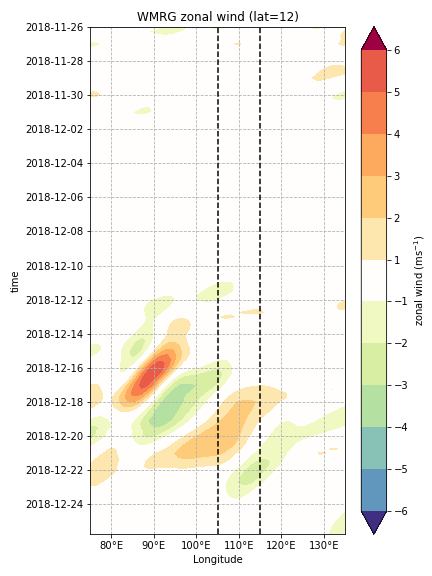

In [218]:
levels=np.arange(-6,7,1)
levels=levels[~np.equal(levels,0)]
div_casestudy=ncs['WMRG'].eastward_wind.sel(lat=8,
                                lon=slice(75,135),
                                time=slice(datetime(2018,11,26),datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'zonal wind (ms$^{-1}$)','ticks':levels})
ax.set(title='WMRG zonal wind (lat=12)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
plt.tight_layout()

# Contours for selected dates

This shows WMRG vorticity but can be edited to change

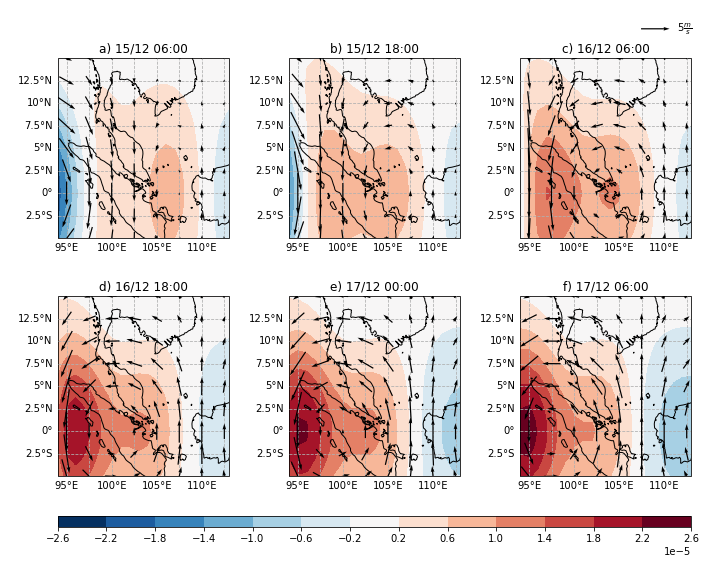

In [266]:
kind='WMRG'
plot_type='vor'

#subset to the times to plot
times=[datetime(2018,12,15,6),datetime(2018,12,15,18),
       datetime(2018,12,16,6),datetime(2018,12,16,18),
       datetime(2018,12,17),datetime(2018,12,17,6)]
subind=np.isin(ncs[kind].time.values.astype('datetime64[s]').tolist(),times)
sub_wave=ncs[kind].sel(time=subind)

#calculate divergence and vorticity
if kind!='Kelvin':
    sub_wave_div=divergence(sub_wave.eastward_wind,sub_wave.northward_wind)
    sub_wave_vor=vorticity(sub_wave.eastward_wind,sub_wave.northward_wind)
else:
    zero_v=sub_wave.eastward_wind.copy(data=np.zeros(np.shape(sub_wave.eastward_wind)))
    sub_wave_div=divergence(sub_wave.eastward_wind,zero_v)
    sub_wave=xr.merge([sub_wave,zero_v.to_dataset(name='northward_wind')])
    
#set variables to plot
toplot=sub_wave_vor if plot_type=='vor' else sub_wave_div
levels=np.arange(-2.6e-5,2.9e-5,4e-6) if plot_type=='vor' else np.arange(-5.7e-6,5.7e-6,6e-7)
wind_xr=sub_wave

#plot and save
fig,axs,cb=contour_quiver_6(toplot,wind_xr,levels,scale=30)
[ax.set_title('{0}) {1}'.format(l,d.strftime('%d/%m %H:00'))) 
     for ax,d,l in zip(np.ravel(axs),sub_wave_div.time.values.astype('datetime64[s]').tolist(),'abcdef')]
plt.savefig('./output_figs/{0}_{1}_casestudy_contourf.png'.format(kind,plot_type),dpi=300)

# Full wind field contourf plot

Create full wind field and plot. Again this can be edited to show vorticity

In [258]:
full_field_u=ncs['Kelvin'].eastward_wind+ncs['R1'].eastward_wind+ncs['R2'].eastward_wind+ncs['WMRG'].eastward_wind
full_field_v=ncs['R1'].northward_wind+ncs['R2'].northward_wind+ncs['WMRG'].northward_wind
full_field_u.attrs=ncs['Kelvin'].eastward_wind.attrs
full_field_v.attrs=ncs['R1'].northward_wind.attrs

full_div=divergence(full_field_u,full_field_v)
full_vor=vorticity(full_field_u,full_field_v)
full_xr=xr.merge([full_field_u.to_dataset(name='eastward_wind'),
                  full_field_v.to_dataset(name='northward_wind'),
                  full_div.to_dataset(name='div'),
                  full_vor.to_dataset(name='vor')])

sub_full=full_xr.sel(time=subind)

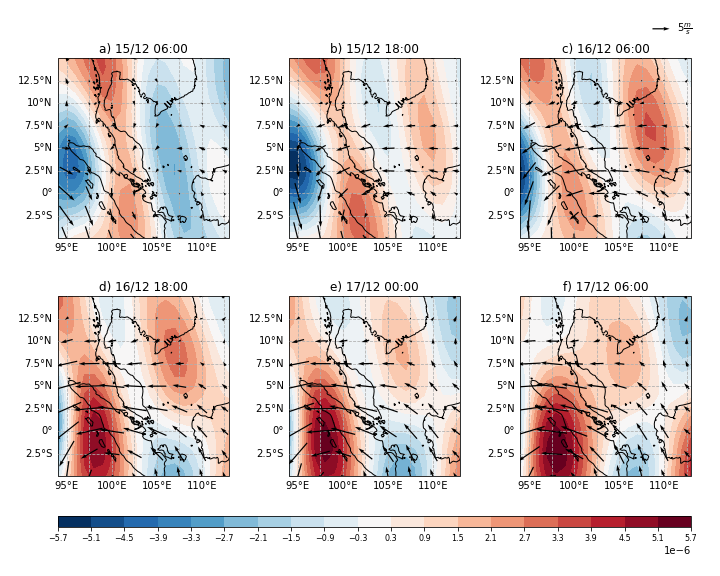

In [267]:
#specify plot type
plot_type='div'

toplot=sub_full.div if plot_type=='div' else sub_full.vor 
wind_xr=sub_full.drop_vars(['div','vor'])
levels=np.arange(-5.7e-6,5.8e-6,6e-7) if plot_type=='div' else np.arange(-2.6e-5,2.9e-5,4e-6)

fig,axs,cb=contour_quiver_6(toplot,wind_xr,levels,scale=50)
cb.ax.tick_params(labelsize=8)
[ax.set_title('{0}) {1}'.format(l,d.strftime('%d/%m %H:00'))) 
     for ax,d,l in zip(np.ravel(axs),sub_wave_div.time.values.astype('datetime64[s]').tolist(),'abcdef')]
plt.savefig('./output_figs/full_{0}_casestudy_contourf.png'.format(plot_type),dpi=300)